In [1]:
# Install required libraries
!pip install -q xgboost scikit-learn imbalanced-learn pandas numpy matplotlib seaborn tensorflow kaggle

# Verify installations
import xgboost as xgb
import sklearn
import tensorflow as tf
print(f"XGBoost version: {xgb.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"TensorFlow version: {tf.__version__}")

XGBoost version: 3.0.5
Scikit-learn version: 1.6.1
TensorFlow version: 2.19.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
import os
project_dir = '/content/drive/MyDrive/IDS_Research'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/results', exist_ok=True)
print(f"Project directory created at: {project_dir}")

Mounted at /content/drive
Project directory created at: /content/drive/MyDrive/IDS_Research


In [4]:
# Upload your kaggle.json file or create it
# Download from: https://www.kaggle.com/settings -> API -> Create New Token

from google.colab import files
import os

# Upload kaggle.json
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)
print("Kaggle API configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [5]:
# Download the dataset
!kaggle datasets download -d dhoogla/csecicids2018 -p /content/data --unzip

# List downloaded files
import os
data_dir = '/content/drive/MyDrive/IDS_Research/data'
print("Downloaded files:")
for file in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  {file}: {size_mb:.2f} MB")

Dataset URL: https://www.kaggle.com/datasets/dhoogla/csecicids2018
License(s): CC-BY-NC-SA-4.0
 91% 550M/604M [00:11<00:01, 31.7MB/s]
100% 604M/604M [00:11<00:00, 57.0MB/s]
Downloaded files:


DATA PREPARATION - PARQUET FILES

Found 10 Parquet files:
  Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet: 79.61 MB
  Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet: 99.14 MB
  DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet: 94.05 MB
  Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet: 96.69 MB
  DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet: 85.35 MB
  Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet: 48.59 MB
  Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet: 27.93 MB
  DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet: 31.90 MB
  DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet: 55.31 MB
  Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet: 72.89 MB

INITIAL EXPLORATION

Sample shape: (771587, 78)
Columns: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd P

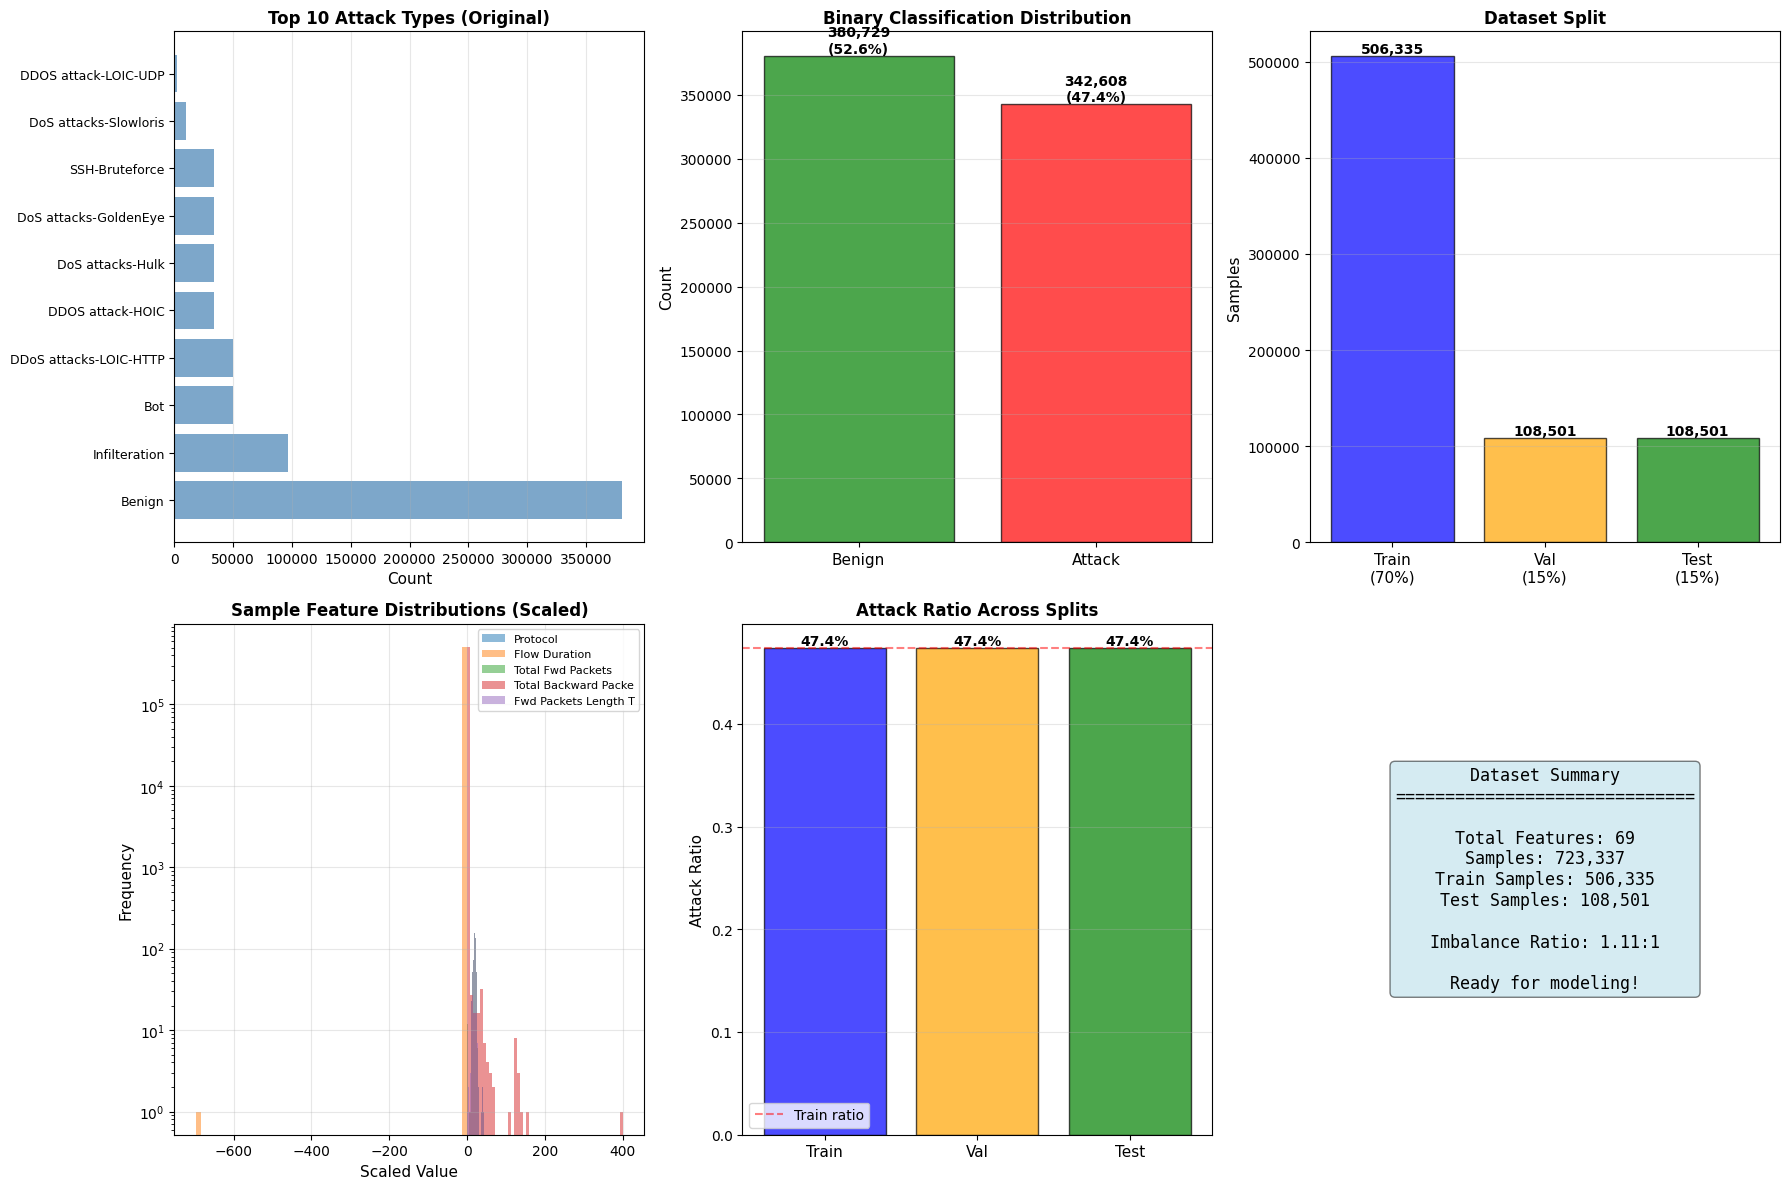


DATA PREPARATION COMPLETE!

You can now proceed to model training:
  1. XGBoost Implementation
  2. Random Forest Baseline
  3. CNN-LSTM Deep Learning Model


In [6]:
# Updated Data Preparation and Preprocessing for Parquet Files
# CSE-CIC-IDS-2018 Dataset - Parquet Format

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DATA PREPARATION - PARQUET FILES")
print("="*80)

# ============================================================================
# STEP 1: LOAD AND EXPLORE PARQUET FILES
# ============================================================================

data_dir = '/content/data'

# List all parquet files
parquet_files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
print(f"\nFound {len(parquet_files)} Parquet files:")
for file in parquet_files:
    file_path = os.path.join(data_dir, file)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  {file}: {size_mb:.2f} MB")

# Load first file for exploration
print(f"\n{'='*80}")
print("INITIAL EXPLORATION")
print(f"{'='*80}\n")

df_sample = pd.read_parquet(os.path.join(data_dir, parquet_files[0]))
print(f"Sample shape: {df_sample.shape}")
print(f"Columns: {df_sample.columns.tolist()}")

# Identify label column
label_candidates = ['Label', 'label', 'Attack', 'attack', 'Class', 'class']
label_col = None
for candidate in label_candidates:
    if candidate in df_sample.columns:
        label_col = candidate
        break

if label_col is None:
    label_col = df_sample.columns[-1]
    print(f"\nAssuming last column '{label_col}' is the label")
else:
    print(f"\nLabel column identified: '{label_col}'")

print(f"\nLabel distribution (sample):")
print(df_sample[label_col].value_counts())

# ============================================================================
# STEP 2: SMART DATA LOADING STRATEGY
# ============================================================================

def load_parquet_files_smart(data_dir, max_samples_per_file=None,
                             balance_classes=True, random_state=42):
    """
    Smart loading strategy for large parquet files

    Parameters:
    - data_dir: directory with parquet files
    - max_samples_per_file: max samples to load per file (None = all)
    - balance_classes: whether to balance attack types
    - random_state: random seed

    Returns:
    - Combined DataFrame
    """
    parquet_files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
    dfs = []

    print(f"\n{'='*80}")
    print("LOADING PARQUET FILES")
    print(f"{'='*80}\n")

    for i, file in enumerate(parquet_files, 1):
        print(f"Loading file {i}/{len(parquet_files)}: {file}")
        df = pd.read_parquet(os.path.join(data_dir, file))

        # Sample if needed
        if max_samples_per_file and len(df) > max_samples_per_file:
            if balance_classes:
                # Sample proportionally from each class
                df = df.groupby(label_col, group_keys=False).apply(
                    lambda x: x.sample(min(len(x), max_samples_per_file // df[label_col].nunique()),
                                     random_state=random_state)
                )
            else:
                df = df.sample(n=max_samples_per_file, random_state=random_state)
            print(f"  Sampled to {len(df):,} rows")
        else:
            print(f"  Loaded {len(df):,} rows")

        dfs.append(df)

    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\n{'='*80}")
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Total rows: {combined_df.shape[0]:,}")
    print(f"Total columns: {combined_df.shape[1]}")
    print(f"{'='*80}\n")

    return combined_df

# Load data with smart sampling
# Adjust max_samples_per_file based on your memory constraints
# For Google Colab: 100000-200000 is reasonable
# For full dataset: set to None (but may take long time)

print("Loading strategy options:")
print("1. Full dataset (may be slow/memory intensive)")
print("2. Balanced sample (recommended for experimentation)")
print("\nChoosing: Balanced sample with 100K samples per file\n")

df = load_parquet_files_smart(
    data_dir,
    max_samples_per_file=100000,  # Adjust based on your needs
    balance_classes=True,
    random_state=42
)

# Display label distribution
print(f"Label distribution in loaded data:")
label_dist = df[label_col].value_counts()
print(label_dist)
print(f"\nPercentages:")
for label, count in label_dist.items():
    print(f"  {label}: {count:,} ({count/len(df)*100:.2f}%)")

# ============================================================================
# STEP 3: DATA CLEANING AND PREPROCESSING
# ============================================================================

print(f"\n{'='*80}")
print("DATA CLEANING")
print(f"{'='*80}\n")

def clean_dataframe(df, label_col):
    """Clean and prepare dataframe"""
    df = df.copy()

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Strip whitespace from string columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()

    print(f"Initial shape: {df.shape}")

    # Remove duplicates
    initial_len = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_len - len(df):,} duplicate rows")

    # Separate features and labels
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Handle infinite values
    print(f"\nHandling infinite values...")
    inf_counts = {}
    for col in X.select_dtypes(include=[np.number]).columns:
        inf_count = np.isinf(X[col]).sum()
        if inf_count > 0:
            inf_counts[col] = inf_count
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)

    if inf_counts:
        print(f"Found infinite values in {len(inf_counts)} columns")
        print(f"Total infinite values: {sum(inf_counts.values()):,}")
    else:
        print("No infinite values found")

    # Handle missing values
    print(f"\nHandling missing values...")
    missing_before = X.isnull().sum().sum()

    if missing_before > 0:
        print(f"Total missing values: {missing_before:,}")

        # Impute numerical columns with median
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        imputer = SimpleImputer(strategy='median')
        X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

        # Drop remaining non-numeric columns with missing values
        X = X.dropna(axis=1)

        missing_after = X.isnull().sum().sum()
        print(f"Missing values after imputation: {missing_after:,}")
    else:
        print("No missing values found")

    # Remove constant columns (zero variance)
    print(f"\nRemoving constant features...")
    constant_cols = []
    for col in X.columns:
        if X[col].nunique() <= 1:
            constant_cols.append(col)

    if constant_cols:
        print(f"Found {len(constant_cols)} constant columns")
        X = X.drop(columns=constant_cols)
    else:
        print("No constant columns found")

    # Remove high-cardinality categorical columns
    print(f"\nChecking categorical columns...")
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"Found {len(categorical_cols)} categorical columns")
        for col in categorical_cols:
            unique_ratio = X[col].nunique() / len(X)
            if unique_ratio > 0.5:  # More than 50% unique values
                print(f"  Dropping high-cardinality column: {col}")
                X = X.drop(columns=[col])
            else:
                # Label encode categorical columns
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                print(f"  Label encoded: {col}")

    print(f"\nFinal feature count: {X.shape[1]}")
    print(f"Final sample count: {X.shape[0]:,}")

    return X, y

# Clean the data
X, y = clean_dataframe(df, label_col)

# ============================================================================
# STEP 4: CREATE BINARY LABELS
# ============================================================================

print(f"\n{'='*80}")
print("LABEL ENCODING")
print(f"{'='*80}\n")

# Create binary classification (Benign vs Attack)
# Adjust the benign label name based on your dataset
benign_labels = ['Benign', 'BENIGN', 'benign', 'Normal', 'NORMAL', 'normal']
benign_label = None

for label in benign_labels:
    if label in y.unique():
        benign_label = label
        break

if benign_label:
    y_binary = (y != benign_label).astype(int)
    print(f"Benign label identified: '{benign_label}'")
else:
    # If no benign label found, assume first label is benign
    most_common_label = y.value_counts().index[0]
    y_binary = (y != most_common_label).astype(int)
    print(f"Warning: No standard benign label found")
    print(f"Assuming most common label is benign: '{most_common_label}'")

print(f"\nBinary label distribution:")
print(f"  Benign (0): {(y_binary == 0).sum():,} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")
print(f"  Attack (1): {(y_binary == 1).sum():,} ({(y_binary == 1).sum()/len(y_binary)*100:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = (y_binary == 0).sum() / max((y_binary == 1).sum(), 1)
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

# Also keep multi-class labels for later analysis
le_multiclass = LabelEncoder()
y_multiclass = le_multiclass.fit_transform(y)

print(f"\nMulti-class labels:")
for i, label in enumerate(le_multiclass.classes_):
    count = (y_multiclass == i).sum()
    print(f"  {i}: {label} - {count:,} samples")

# ============================================================================
# STEP 5: TRAIN-TEST SPLIT
# ============================================================================

print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print(f"{'='*80}\n")

# Split: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary,
    test_size=0.3,
    random_state=42,
    stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"Training - Attack ratio:   {y_train.sum()/len(y_train)*100:.2f}%")
print(f"Validation - Attack ratio: {y_val.sum()/len(y_val)*100:.2f}%")
print(f"Test - Attack ratio:       {y_test.sum()/len(y_test)*100:.2f}%")

# ============================================================================
# STEP 6: FEATURE SCALING
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE SCALING")
print(f"{'='*80}\n")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform all sets
print("Fitting scaler on training data...")
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print(f"\nScaled data statistics:")
print(f"  Mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Std:  {X_train_scaled.std().mean():.6f}")
print(f"  Min:  {X_train_scaled.min().min():.2f}")
print(f"  Max:  {X_train_scaled.max().max():.2f}")

# ============================================================================
# STEP 7: SAVE PROCESSED DATA (OPTIONAL)
# ============================================================================

print(f"\n{'='*80}")
print("SAVING PROCESSED DATA")
print(f"{'='*80}\n")

# Create directory for processed data
os.makedirs(f'{project_dir}/processed_data', exist_ok=True)

# Save processed datasets
print("Saving processed datasets...")
X_train_scaled.to_parquet(f'{project_dir}/processed_data/X_train_scaled.parquet')
X_val_scaled.to_parquet(f'{project_dir}/processed_data/X_val_scaled.parquet')
X_test_scaled.to_parquet(f'{project_dir}/processed_data/X_test_scaled.parquet')

y_train.to_frame().to_parquet(f'{project_dir}/processed_data/y_train.parquet')
y_val.to_frame().to_parquet(f'{project_dir}/processed_data/y_val.parquet')
y_test.to_frame().to_parquet(f'{project_dir}/processed_data/y_test.parquet')

# Save scaler and other objects
import pickle

with open(f'{project_dir}/processed_data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(f'{project_dir}/processed_data/feature_names.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

with open(f'{project_dir}/processed_data/label_encoder_multiclass.pkl', 'wb') as f:
    pickle.dump(le_multiclass, f)

print("All processed data saved!")
print(f"\nSaved files:")
print(f"  - X_train_scaled.parquet ({X_train_scaled.shape})")
print(f"  - X_val_scaled.parquet ({X_val_scaled.shape})")
print(f"  - X_test_scaled.parquet ({X_test_scaled.shape})")
print(f"  - y_train.parquet, y_val.parquet, y_test.parquet")
print(f"  - scaler.pkl, feature_names.pkl, label_encoder_multiclass.pkl")

# ============================================================================
# STEP 8: DATA VISUALIZATION
# ============================================================================

print(f"\n{'='*80}")
print("DATA VISUALIZATION")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Class distribution - Original
ax = axes[0, 0]
label_counts = y.value_counts().head(10)
ax.barh(range(len(label_counts)), label_counts.values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(label_counts)))
ax.set_yticklabels([str(label)[:30] for label in label_counts.index], fontsize=9)
ax.set_xlabel('Count', fontsize=11)
ax.set_title('Top 10 Attack Types (Original)', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 2. Binary class distribution
ax = axes[0, 1]
binary_counts = pd.Series({'Benign': (y_binary == 0).sum(), 'Attack': (y_binary == 1).sum()})
colors = ['green', 'red']
ax.bar(range(len(binary_counts)), binary_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(binary_counts)))
ax.set_xticklabels(binary_counts.index, fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Binary Classification Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(binary_counts.values):
    ax.text(i, v, f'{v:,}\n({v/len(y_binary)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Train-Val-Test split
ax = axes[0, 2]
split_counts = [len(X_train), len(X_val), len(X_test)]
split_labels = ['Train\n(70%)', 'Val\n(15%)', 'Test\n(15%)']
ax.bar(range(3), split_counts, color=['blue', 'orange', 'green'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(3))
ax.set_xticklabels(split_labels, fontsize=11)
ax.set_ylabel('Samples', fontsize=11)
ax.set_title('Dataset Split', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(split_counts):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Feature distribution (sample features)
ax = axes[1, 0]
sample_cols = X_train_scaled.columns[:5]
for col in sample_cols:
    ax.hist(X_train_scaled[col], bins=50, alpha=0.5, label=str(col)[:20])
ax.set_xlabel('Scaled Value', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Sample Feature Distributions (Scaled)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# 5. Imbalance ratio visualization
ax = axes[1, 1]
ratios = [
    y_train.sum()/len(y_train),
    y_val.sum()/len(y_val),
    y_test.sum()/len(y_test)
]
ax.bar(range(3), ratios, color=['blue', 'orange', 'green'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(3))
ax.set_xticklabels(['Train', 'Val', 'Test'], fontsize=11)
ax.set_ylabel('Attack Ratio', fontsize=11)
ax.set_title('Attack Ratio Across Splits', fontsize=12, fontweight='bold')
ax.axhline(y=ratios[0], color='r', linestyle='--', alpha=0.5, label='Train ratio')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(ratios):
    ax.text(i, v, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Feature count summary
ax = axes[1, 2]
info_data = {
    'Total Features': X.shape[1],
    'Samples': len(X),
    'Train Samples': len(X_train),
    'Test Samples': len(X_test)
}
ax.axis('off')
summary_text = "Dataset Summary\n" + "="*30 + "\n\n"
for key, value in info_data.items():
    summary_text += f"{key}: {value:,}\n"
summary_text += f"\nImbalance Ratio: {imbalance_ratio:.2f}:1"
summary_text += f"\n\nReady for modeling!"
ax.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
        family='monospace')

plt.tight_layout()
plt.savefig(f'{project_dir}/results/data_preprocessing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE!")
print("="*80)
print("\nYou can now proceed to model training:")
print("  1. XGBoost Implementation")
print("  2. Random Forest Baseline")
print("  3. CNN-LSTM Deep Learning Model")
print("="*80)

In [7]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import time

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method='hist',  # Faster for large datasets
    n_jobs=-1
)

# Train the model
print("Training XGBoost model...")
start_time = time.time()

xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

Training XGBoost model...
[0]	validation_0-logloss:0.64116
[1]	validation_0-logloss:0.59629
[2]	validation_0-logloss:0.55811
[3]	validation_0-logloss:0.52395
[4]	validation_0-logloss:0.49450
[5]	validation_0-logloss:0.46922
[6]	validation_0-logloss:0.44739
[7]	validation_0-logloss:0.42856
[8]	validation_0-logloss:0.41199
[9]	validation_0-logloss:0.39759
[10]	validation_0-logloss:0.38491
[11]	validation_0-logloss:0.37234
[12]	validation_0-logloss:0.36256
[13]	validation_0-logloss:0.35254
[14]	validation_0-logloss:0.34462
[15]	validation_0-logloss:0.33660
[16]	validation_0-logloss:0.33028
[17]	validation_0-logloss:0.32466
[18]	validation_0-logloss:0.31880
[19]	validation_0-logloss:0.31357
[20]	validation_0-logloss:0.30902
[21]	validation_0-logloss:0.30527
[22]	validation_0-logloss:0.30152
[23]	validation_0-logloss:0.29822
[24]	validation_0-logloss:0.29482
[25]	validation_0-logloss:0.29193
[26]	validation_0-logloss:0.28961
[27]	validation_0-logloss:0.28765
[28]	validation_0-logloss:0.2858

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_val = xgb_model.predict(X_val_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Prediction probabilities
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # False Positive Rate
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall (Detection Rate): {recall*100:.2f}%")
    print(f"F1-Score: {f1*100:.2f}%")
    print(f"False Positive Rate: {fpr*100:.2f}%")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr
    }

# Evaluate on all sets
train_metrics = calculate_metrics(y_train, y_pred_train, "Training Set")
val_metrics = calculate_metrics(y_val, y_pred_val, "Validation Set")
test_metrics = calculate_metrics(y_test, y_pred_test, "Test Set")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


Training Set Metrics:
Accuracy: 87.85%
Precision: 95.84%
Recall (Detection Rate): 77.72%
F1-Score: 85.83%
False Positive Rate: 3.04%

Validation Set Metrics:
Accuracy: 87.65%
Precision: 95.62%
Recall (Detection Rate): 77.48%
F1-Score: 85.60%
False Positive Rate: 3.20%

Test Set Metrics:
Accuracy: 87.63%
Precision: 95.62%
Recall (Detection Rate): 77.44%
F1-Score: 85.57%
False Positive Rate: 3.19%

ROC-AUC Score: 0.9505


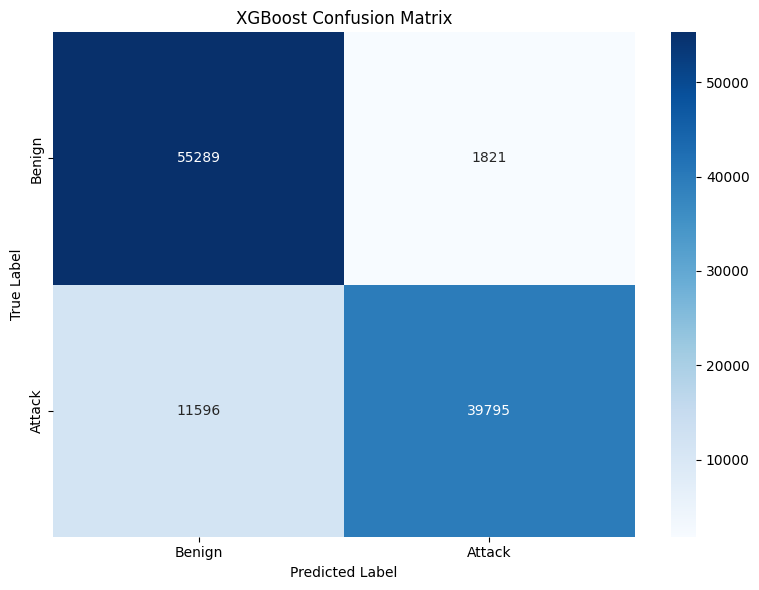


Confusion Matrix Breakdown:
True Negatives (Correct Benign): 55289
False Positives (Benign as Attack): 1821
False Negatives (Missed Attacks): 11596
True Positives (Correct Attacks): 39795


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{project_dir}/results/xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correct Benign): {tn}")
print(f"False Positives (Benign as Attack): {fp}")
print(f"False Negatives (Missed Attacks): {fn}")
print(f"True Positives (Correct Attacks): {tp}")

Top 20 Most Important Features:
                   feature  importance
48          ECE Flag Count    0.271478
6    Fwd Packet Length Max    0.145760
60        Fwd Seg Size Min    0.139767
8   Fwd Packet Length Mean    0.125582
13   Bwd Packet Length Std    0.055233
20           Fwd IAT Total    0.033301
44          PSH Flag Count    0.023927
10   Bwd Packet Length Max    0.020870
37       Packet Length Max    0.015133
16           Flow IAT Mean    0.015096
57      Init Fwd Win Bytes    0.011020
3   Total Backward Packets    0.010076
9    Fwd Packet Length Std    0.009551
59    Fwd Act Data Packets    0.008843
19            Flow IAT Min    0.008168
15          Flow Packets/s    0.007697
18            Flow IAT Max    0.007013
58      Init Bwd Win Bytes    0.005909
32       Fwd Header Length    0.005467
34           Fwd Packets/s    0.005281


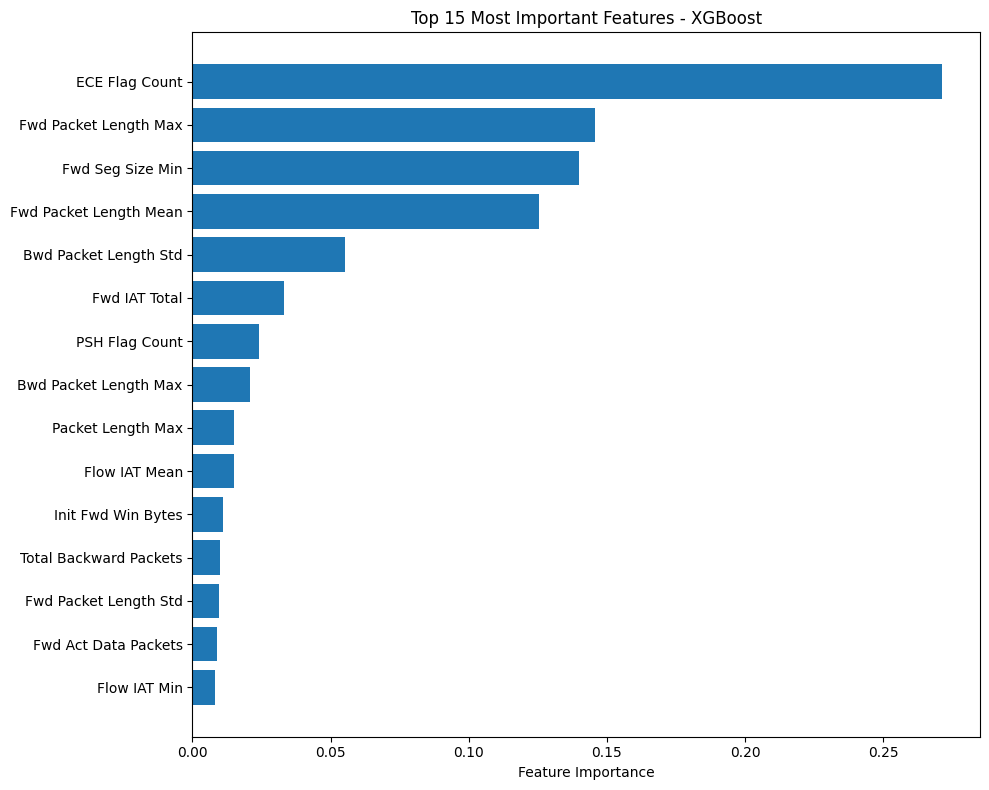

In [10]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{project_dir}/results/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
import pickle

# Save XGBoost model
model_path = f'{project_dir}/models/xgboost_ids_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(xgb_model, f)

# Save scaler
scaler_path = f'{project_dir}/models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")

# Save feature names
feature_names_path = f'{project_dir}/models/feature_names.pkl'
with open(feature_names_path, 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print(f"Feature names saved to: {feature_names_path}")

Model saved to: /content/drive/MyDrive/IDS_Research/models/xgboost_ids_model.pkl
Scaler saved to: /content/drive/MyDrive/IDS_Research/models/scaler.pkl
Feature names saved to: /content/drive/MyDrive/IDS_Research/models/feature_names.pkl
